In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
G = 6.67430e-8
c = 2.99792458e10
M_sun = 1.98847e33

L0 = G*M_sun/c**2
rho_scale = (G**3*M_sun**2)/(c**6)

def rhat_to_km(rhat):
    return (rhat*L0)/1e5

In [3]:
rho_r_norm = 1e13          # g/cm^3
Pc2_norm_number = 1.5689e31  # number given for P/c^2
p_norm = Pc2_norm_number / c**2   # convert to g/cm^3

def make_eos(Gamma):
    # K such that p = K rho_r^Gamma matches the normalization point
    K0 = p_norm / (rho_r_norm**Gamma)

    def eos_from_rhor(rho_r, K):
        # p = P/c^2 in g/cm^3
        p = K * rho_r**Gamma
        rho = rho_r + p/(Gamma - 1.0)
        return p, rho

    def rhor_from_p(p, K):
        return (p/K)**(1.0/Gamma)

    return K0, eos_from_rhor, rhor_from_p

In [4]:
def make_solver(Gamma):
    K0, eos_from_rhor, rhor_from_p = make_eos(Gamma)

    def tov_rhs(rhat, y, K):
        mhat, phat = y
        if rhat <= 0:
            return (0.0, 0.0)

        p = phat / rho_scale
        if p <= 0 or (not np.isfinite(p)):
            rhohat = 0.0
        else:
            rhor = rhor_from_p(p, K)
            _, rho = eos_from_rhor(rhor, K)
            rhohat = rho * rho_scale

        denom = rhat*(rhat - 2.0*mhat)
        if denom <= 0 or (not np.isfinite(denom)):
            return (0.0, -1e30)

        dm = 4*np.pi * rhat**2 * rhohat
        dp = - (mhat + 4*np.pi*rhat**3*phat) * (rhohat + phat) / denom
        return (dm, dp)

    def integrate_star(rho_r_c, K, r0=1e-6, rmax=400.0):
        p_c, rho_c = eos_from_rhor(rho_r_c, K)
        if (not np.isfinite(p_c)) or p_c <= 0:
            return np.nan, np.nan, "bad_pc"

        phat0 = p_c * rho_scale
        rhohat0 = rho_c * rho_scale
        mhat0 = (4*np.pi/3) * r0**3 * rhohat0

        def ev_surface(rhat, y):  # p_hat hits 0
            return y[1]
        ev_surface.terminal = True
        ev_surface.direction = -1.0

        def ev_horizon(rhat, y):  # r-2m hits 0
            return rhat - 2.0*y[0]
        ev_horizon.terminal = True
        ev_horizon.direction = -1.0

        sol = solve_ivp(
            fun=lambda rr, yy: tov_rhs(rr, yy, K),
            t_span=(r0, rmax),
            y0=(mhat0, phat0),
            events=(ev_surface, ev_horizon),
            rtol=1e-8, atol=1e-10,
            max_step=0.2,
            method="Radau"
        )

        if len(sol.t_events[0]) > 0:
            Rhat = sol.t_events[0][0]
            Mhat = sol.y_events[0][0][0]
            return Mhat, Rhat, "ok"
        if len(sol.t_events[1]) > 0:
            return np.nan, np.nan, "horizon"
        return np.nan, np.nan, "nosurface"

    def Mmax_for_K(K, rho_lo=1e13, rho_hi=3e18, N=60):
        rho_grid = np.logspace(np.log10(rho_lo), np.log10(rho_hi), N)
        M = np.full_like(rho_grid, np.nan, dtype=float)
        R = np.full_like(rho_grid, np.nan, dtype=float)

        for i, rho_c in enumerate(rho_grid):
            Mi, Ri, tag = integrate_star(rho_c, K)
            M[i], R[i] = Mi, Ri

        ok = np.isfinite(M) & np.isfinite(R) & (M>0) & (R>0)
        if not np.any(ok):
            return np.nan, np.nan
        j = np.argmax(M[ok])
        j = np.where(ok)[0][j]
        return M[j], R[j]

    return K0, integrate_star, Mmax_for_K

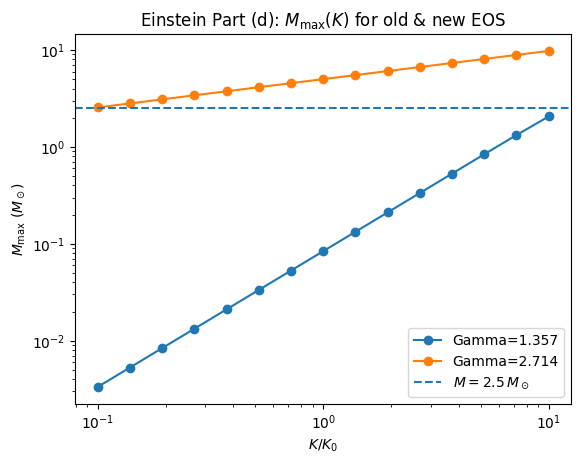

In [5]:
Gamma_old = 1.3569
Gamma_new = 2*Gamma_old  # 2.7138

Gamma_list = [Gamma_old, Gamma_new]

K_factors = np.logspace(-1, 1, 15)  # K/K0 scan

plt.figure()

for Gamma in Gamma_list:
    K0, integrate_star, Mmax_for_K = make_solver(Gamma)

    Mmax_list = []
    for fac in K_factors:
        K = K0 * fac
        Mmax, Rmax = Mmax_for_K(K, rho_lo=1e13, rho_hi=3e18, N=70)
        Mmax_list.append(Mmax)

    Mmax_list = np.array(Mmax_list)
    plt.loglog(K_factors, Mmax_list, marker="o", label=f"Gamma={Gamma:.4g}")

# >>> BURASI EKLENDİ <<<
plt.axhline(2.5, linestyle="--", label=r"$M=2.5\,M_\odot$")

plt.xlabel(r"$K/K_0$")
plt.ylabel(r"$M_{\max}\ (M_\odot)$")
plt.title("Einstein Part (d): $M_{\\max}(K)$ for old & new EOS")
plt.legend()
plt.show()

In [6]:
for Gamma in Gamma_list:
    K0, integrate_star, Mmax_for_K = make_solver(Gamma)

    Mmax_list = []
    for fac in K_factors:
        K = K0 * fac
        Mmax, _ = Mmax_for_K(K, rho_lo=1e13, rho_hi=3e18, N=70)
        Mmax_list.append(Mmax)
    Mmax_list = np.array(Mmax_list)

    ok = np.isfinite(Mmax_list) & (Mmax_list >= 2.5)
    print(f"\nGamma={Gamma:.4g}")
    if np.any(ok):
        print("Allowed by Mmax >= 2.5 Msun within scan:")
        print(f"K/K0 in [{K_factors[ok].min():.4g}, {K_factors[ok].max():.4g}]")
    else:
        print("No K in scanned range reaches 2.5 Msun.")


Gamma=1.357
No K in scanned range reaches 2.5 Msun.

Gamma=2.714
Allowed by Mmax >= 2.5 Msun within scan:
K/K0 in [0.1, 10]
